# Importing all Libraries

In [1]:
import io
import requests
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel

# Configuration

In [2]:
MAX_WORDS = 10000 # Max words for LSTM tokenizer
MAX_LENGTH_LSTM = 200 # Sequence length for LSTM
MAX_LENGTH_BERT = 200 # Sequence length for BERT (can be different if needed, but keep consistent for simplicity)
LSTM_DROPOUT_RATE = 0.3
BERT_MODEL_NAME = 'bert-base-uncased'
EPOCHS = 10 # Reduced epochs for faster demonstration, use EarlyStopping
BATCH_SIZE = 32
PATIENCE = 2 # Patience for EarlyStopping

#Download and Load Dataset

In [3]:
print("Downloading dataset...")
url = "https://github.com/panagiotisanagnostou/AI-GA/blob/main/ai-ga-dataset.csv?raw=true"
try:
    response = requests.get(url).content
    df = pd.read_csv(io.StringIO(response.decode('utf-8')))
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error downloading or reading dataset: {e}")
    exit() # Exit if dataset loading fails


Dataset loaded successfully.


#Preprocess Text

In [4]:
print("Preprocessing text...")
def clean_text(text):
    if isinstance(text, str): # Check if text is a string
        text = text.lower()
        text = re.sub(f"[{string.punctuation}]", "", text)
        text = re.sub("\d+", "", text)
    else:
        text = "" # Return empty string for non-string inputs (like NaN)
    return text


Preprocessing text...


In [5]:
# Ensure 'abstract' column exists and handle potential NaN values
if 'abstract' in df.columns:
    df["abstract"] = df["abstract"].fillna("").apply(clean_text)
    # Remove rows where abstract became empty after cleaning (or was originally empty/NaN)
    df = df[df["abstract"] != ""]
else:
    print("Error: 'abstract' column not found in the dataset.")
    exit()

In [6]:
# Ensure 'label' column exists and handle potential non-numeric values
if 'label' in df.columns:
     # Attempt to convert to numeric, coercing errors to NaN, then fillna with a default (e.g., 0 or drop)
    df['label'] = pd.to_numeric(df['label'], errors='coerce')
    df.dropna(subset=['label'], inplace=True) # Drop rows where label couldn't be converted
    df['label'] = df['label'].astype(int) # Convert valid labels to int
    y = np.array(df["label"])
else:
    print("Error: 'label' column not found in the dataset.")
    exit()


In [7]:
# Check if dataframe is empty after cleaning
if df.empty:
    print("Error: No valid data remaining after preprocessing.")
    exit()

print(f"Dataset shape after preprocessing: {df.shape}")

Dataset shape after preprocessing: (28662, 3)


Split Dataset

In [8]:
print("Splitting dataset...")
train_texts, test_texts, y_train, y_test = train_test_split(
    df["abstract"], y, test_size=0.2, random_state=42, stratify=y # Added stratify
)
print(f"Train samples: {len(train_texts)}, Test samples: {len(test_texts)}")

Splitting dataset...
Train samples: 22929, Test samples: 5733


# LSTM Data Preparation

In [10]:
print("Preparing data for LSTM...")
lstm_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(train_texts)
train_sequences_lstm = lstm_tokenizer.texts_to_sequences(train_texts)
test_sequences_lstm = lstm_tokenizer.texts_to_sequences(test_texts)

X_train_lstm = pad_sequences(train_sequences_lstm, maxlen=MAX_LENGTH_LSTM, padding="post", truncating="post")
X_test_lstm = pad_sequences(test_sequences_lstm, maxlen=MAX_LENGTH_LSTM, padding="post", truncating="post")


Preparing data for LSTM...


# Build and Train LSTM Model

In [11]:
print("Building LSTM model...")
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_WORDS, 64, input_length=MAX_LENGTH_LSTM),
    tf.keras.layers.Dropout(LSTM_DROPOUT_RATE),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(LSTM_DROPOUT_RATE),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(LSTM_DROPOUT_RATE),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(LSTM_DROPOUT_RATE),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)


Building LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...


In [ ]:
history_lstm = lstm_model.fit(X_train_lstm, y_train,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_test_lstm, y_test),
                              callbacks=[early_stopping])

Epoch 1/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.8876 - loss: 0.2421 - val_accuracy: 0.9803 - val_loss: 0.0606
Epoch 2/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9884 - loss: 0.0373 - val_accuracy: 0.9864 - val_loss: 0.0439
Epoch 3/10
139/717 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9915 - loss: 0.0249

# Evaluate LSTM Model

In [ ]:
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"\nLSTM Model Test Accuracy: {test_acc_lstm:.4f}")
print(f"LSTM Model Test Loss: {test_loss_lstm:.4f}")


LSTM Model Test Accuracy: 0.9937
LSTM Model Test Loss: 0.0171


# BERT Data Preparation

In [ ]:
print("\nPreparing data for BERT...")
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)


Preparing data for BERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def encode_texts_bert(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [ ]:
train_encodings = encode_texts_bert(train_texts, bert_tokenizer, MAX_LENGTH_BERT)
test_encodings = encode_texts_bert(test_texts, bert_tokenizer, MAX_LENGTH_BERT)

# Build and Train BERT Model

In [ ]:
# Input for BERT needs to be a dictionary or tuple/list for tf.data or direct feeding
X_train_bert = {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]}
X_test_bert = {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]}


print("Building BERT model...")
bert_base = TFBertModel.from_pretrained(BERT_MODEL_NAME)

Building BERT model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Define inputs matching the tokenizer output keys
input_ids = tf.keras.Input(shape=(MAX_LENGTH_BERT,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(MAX_LENGTH_BERT,), dtype=tf.int32, name="attention_mask")


In [ ]:
# Use a Lambda layer to wrap the BERT call and get the pooler output
def get_bert_pooler_output(inputs):
    input_ids_layer, attention_mask_layer = inputs
    # Make bert_base non-trainable if you only want to use it as feature extractor initially
    # bert_base.trainable = False
    return bert_base(input_ids=input_ids_layer, attention_mask=attention_mask_layer).pooler_output

bert_output = tf.keras.layers.Lambda(
    get_bert_pooler_output,
    output_shape=(bert_base.config.hidden_size,) # Specify output shape
)([input_ids, attention_mask])


In [ ]:
# Classifier layers
dropout_bert = tf.keras.layers.Dropout(0.2)(bert_output) # Add dropout
dense_bert = tf.keras.layers.Dense(32, activation="relu")(dropout_bert)
output_bert = tf.keras.layers.Dense(1, activation="sigmoid")(dense_bert)

In [ ]:
bert_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output_bert)


In [ ]:
# Consider a slower learning rate for fine-tuning BERT
optimizer_bert = tf.keras.optimizers.Adam(learning_rate=5e-5) # Standard LR for BERT fine-tuning
bert_model.compile(loss="binary_crossentropy", optimizer=optimizer_bert, metrics=["accuracy"])
bert_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 768)            │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 768)            │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │         24,608 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,641 (96.25 KB)

 Trainable params: 24,641 (96.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Training BERT model...")
history_bert = bert_model.fit(X_train_bert, y_train,
                              epochs=EPOCHS, # BERT often needs fewer epochs
                              batch_size=BATCH_SIZE, # Smaller batch size often used for BERT
                              validation_data=(X_test_bert, y_test),
                              callbacks=[early_stopping])

Training BERT model...
Epoch 1/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 383s 510ms/step - accuracy: 0.5856 - loss: 0.6757 - val_accuracy: 0.7757 - val_loss: 0.5495
Epoch 2/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 368s 499ms/step - accuracy: 0.7511 - loss: 0.5496 - val_accuracy: 0.8266 - val_loss: 0.4621
Epoch 3/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 382s 499ms/step - accuracy: 0.7945 - loss: 0.4736 - val_accuracy: 0.8432 - val_loss: 0.4109
Epoch 4/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 381s 498ms/step - accuracy: 0.8203 - loss: 0.4229 - val_accuracy: 0.8624 - val_loss: 0.3668
Epoch 5/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 357s 498ms/step - accuracy: 0.8334 - loss: 0.3936 - val_accuracy: 0.8676 - val_loss: 0.3434
Epoch 6/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 375s 488ms/step - accuracy: 0.8420 - loss: 0.3779 - val_accuracy: 0.8737 - val_loss: 0.3254
Epoch 7/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 357s 499ms/step - accuracy: 0.8518 - loss: 0.3557 - val_accuracy: 0.8777 - val_loss: 0.3111
Epoch 8/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 382s 499ms/st

In [ ]:
# --- Evaluate BERT Model ---
test_loss_bert, test_acc_bert = bert_model.evaluate(X_test_bert, y_test, verbose=0)
print(f"\nBERT Model Test Accuracy: {test_acc_bert:.4f}")
print(f"BERT Model Test Loss: {test_loss_bert:.4f}")


BERT Model Test Accuracy: 0.8887
BERT Model Test Loss: 0.2842


In [ ]:
# --- Build and Train Hybrid BERT + LSTM Model ---
print("\nBuilding Hybrid BERT + LSTM model...")

# Reload or reuse the bert_base model.
bert_base_hybrid = TFBertModel.from_pretrained(BERT_MODEL_NAME)


Building Hybrid BERT + LSTM model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
input_ids_hybrid = tf.keras.layers.Input(shape=(MAX_LENGTH_BERT,), dtype=tf.int32, name='input_ids') # Changed name
attention_mask_hybrid = tf.keras.layers.Input(shape=(MAX_LENGTH_BERT,), dtype=tf.int32, name='attention_mask') # Changed name


In [ ]:
def get_bert_sequence_output(inputs):
    input_ids_layer, attention_mask_layer = inputs
    return bert_base_hybrid(input_ids=input_ids_layer, attention_mask=attention_mask_layer).last_hidden_state


In [ ]:
# Wrap the BERT call in a Lambda layer
bert_sequence_output_hybrid = tf.keras.layers.Lambda(
    get_bert_sequence_output,
    output_shape=(MAX_LENGTH_BERT, bert_base_hybrid.config.hidden_size),
    name='bert_sequence_output'
)([input_ids_hybrid, attention_mask_hybrid])

In [ ]:
# Apply LSTM layer(s)
lstm_layer = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)(bert_sequence_output_hybrid)


In [ ]:
# Output layer
output_hybrid = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_layer)

In [ ]:
# Create the Model - Input names are now 'input_ids' and 'attention_mask'
hybrid_model = tf.keras.Model(inputs=[input_ids_hybrid, attention_mask_hybrid], outputs=output_hybrid)


In [ ]:
# Compile the Model
optimizer_hybrid = tf.keras.optimizers.Adam(learning_rate=5e-5)
hybrid_model.compile(optimizer=optimizer_hybrid, loss='binary_crossentropy', metrics=['accuracy'])
hybrid_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_sequence_output      │ (None, 200, 768)       │              0 │ input_ids[0][0],       │
│ (Lambda)                  │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 64)             │        213,248 │ bert_sequence_output[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ lstm_2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 213,313 (833.25 KB)

 Trainable params: 213,313 (833.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Training Hybrid model...")
# Train the Hybrid model - No change needed here as X_train_bert/X_test_bert keys now match input names
history_hybrid = hybrid_model.fit(
    X_train_bert, # Contains keys 'input_ids' and 'attention_mask'
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_bert, y_test), # Also contains 'input_ids' and 'attention_mask'
    callbacks=[early_stopping]
)

Training Hybrid model...
Epoch 1/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 854s 1s/step - accuracy: 0.7164 - loss: 0.5377 - val_accuracy: 0.9325 - val_loss: 0.1960
Epoch 2/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 859s 1s/step - accuracy: 0.9047 - loss: 0.2423 - val_accuracy: 0.9562 - val_loss: 0.1402
Epoch 3/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 866s 1s/step - accuracy: 0.9314 - loss: 0.1855 - val_accuracy: 0.9646 - val_loss: 0.1165
Epoch 4/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - accuracy: 0.9392 - loss: 0.1675 - val_accuracy: 0.9690 - val_loss: 0.1018
Epoch 5/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 860s 1s/step - accuracy: 0.9495 - loss: 0.1418 - val_accuracy: 0.9747 - val_loss: 0.0863
Epoch 6/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 831s 1s/step - accuracy: 0.9526 - loss: 0.1353 - val_accuracy: 0.9784 - val_loss: 0.0763
Epoch 7/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 858s 1s/step - accuracy: 0.9598 - loss: 0.1158 - val_accuracy: 0.9808 - val_loss: 0.0714
Epoch 8/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 863s 1s/step - accuracy: 0.9644 

In [ ]:
# --- Evaluate Hybrid Model ---
test_loss_hybrid, test_acc_hybrid = hybrid_model.evaluate(X_test_bert, y_test, verbose=0)
print(f"\nHybrid Model Test Accuracy: {test_acc_hybrid:.4f}")
print(f"Hybrid Model Test Loss: {test_loss_hybrid:.4f}")


Hybrid Model Test Accuracy: 0.9827
Hybrid Model Test Loss: 0.0596


In [ ]:
# --- Compare Model Performance ---
print("\nComparing model performance...")

# Function to safely get the best validation accuracy based on validation loss
def get_best_val_accuracy(history):
    if not history or not history.history or 'val_loss' not in history.history or 'val_accuracy' not in history.history:
        return 0.0 # Return 0 if history is invalid or missing keys
    best_epoch = np.argmin(history.history['val_loss'])
    return history.history['val_accuracy'][best_epoch]


Comparing model performance...


In [ ]:
# Get accuracies from the epoch with the best validation loss
best_acc_lstm = get_best_val_accuracy(history_lstm)
best_acc_bert = get_best_val_accuracy(history_bert)
best_acc_hybrid = get_best_val_accuracy(history_hybrid)

In [ ]:
models = ["LSTM", "BERT", "Hybrid BERT+LSTM"]
accuracies = [best_acc_lstm, best_acc_bert, best_acc_hybrid]

(0.8387144327163696, 1.0434066206216812)

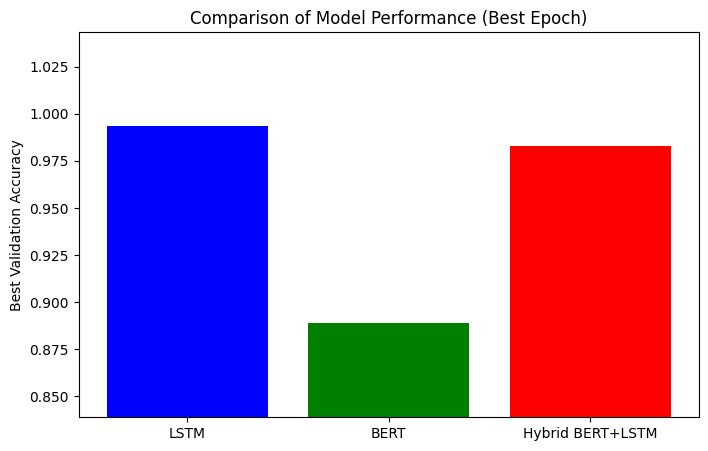

In [ ]:
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=["blue", "green", "red"])
plt.ylabel("Best Validation Accuracy")
plt.title("Comparison of Model Performance (Best Epoch)")
plt.ylim(bottom=max(0, min(accuracies) - 0.05)) # Adjust y-axis limits

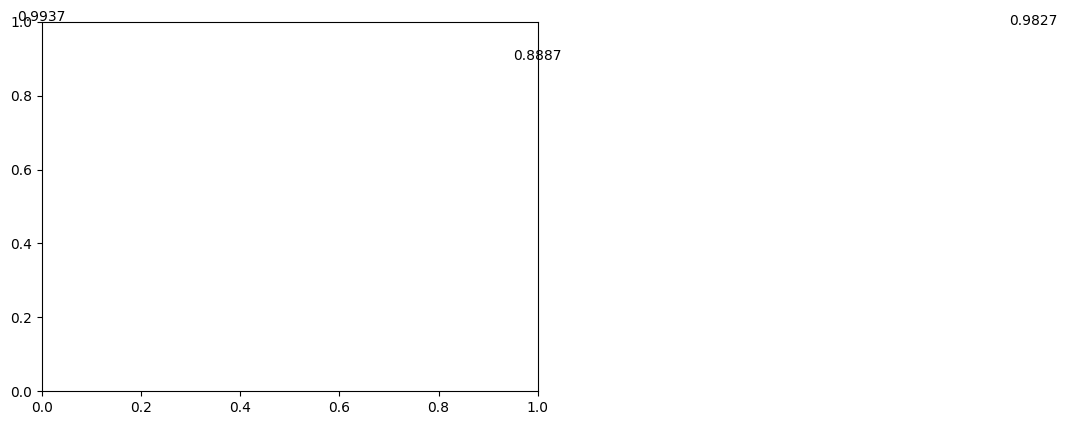

In [ ]:
# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') # Add text labels

plt.show()

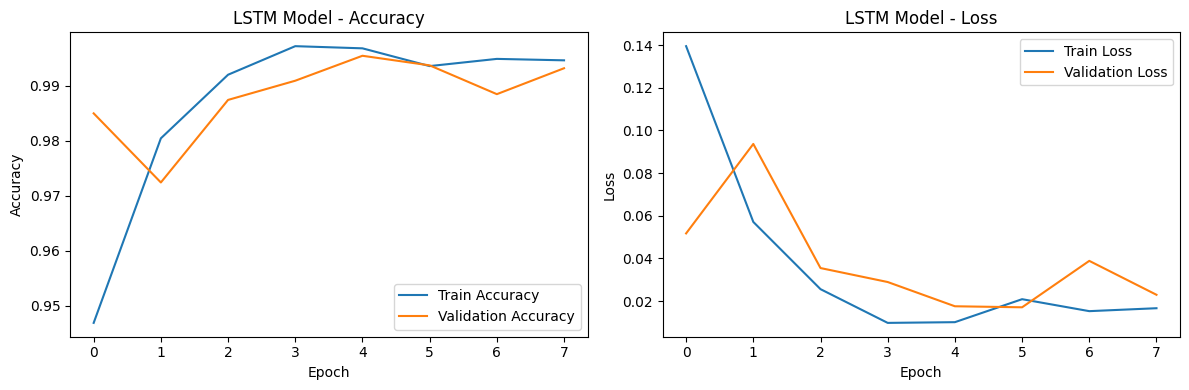

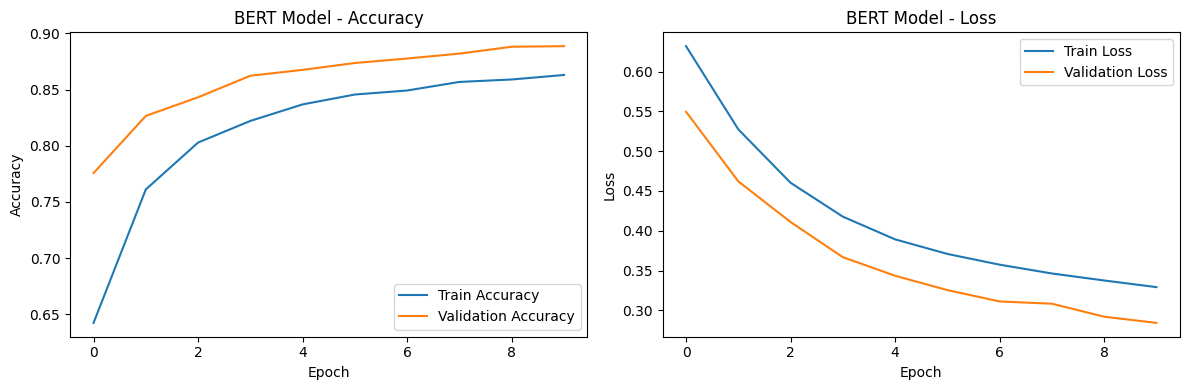

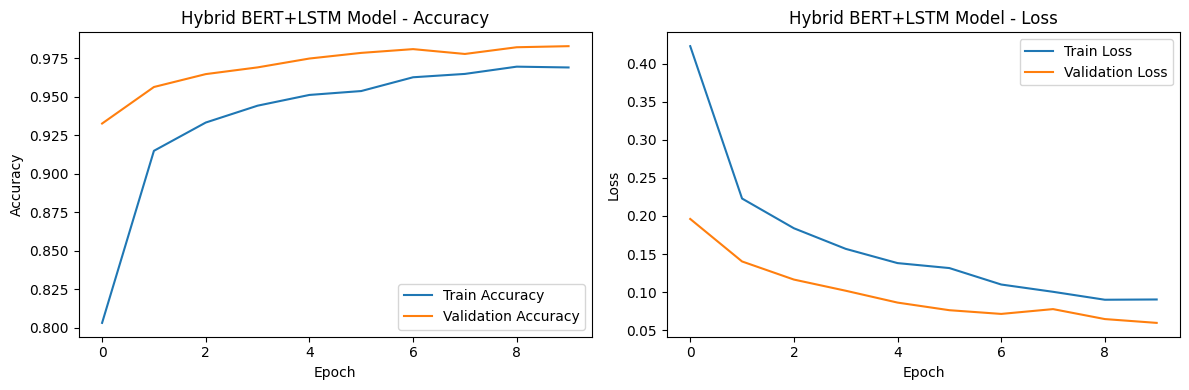

In [ ]:
def plot_history(history, title):
    if history and 'accuracy' in history.history:
        plt.figure(figsize=(12, 4))
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{title} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{title} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Plot all models
plot_history(history_lstm, "LSTM Model")
plot_history(history_bert, "BERT Model")
plot_history(history_hybrid, "Hybrid BERT+LSTM Model")


In [ ]:
# --- Save Models ---
print("Saving models...")
try:
    lstm_model.save("lstm_model.keras") # Use the recommended .keras format
    bert_model.save("bert_model.keras")
    hybrid_model.save("hybrid_model.keras")
    print("Models saved successfully in .keras format.")
except Exception as e:
    print(f"Error saving models: {e}")
    # Fallback to H5 if needed, though .keras is preferred
    try:
        print("Attempting to save in .h5 format...")
        lstm_model.save("lstm_model.h5")
        bert_model.save("bert_model.h5")
        hybrid_model.save("hybrid_model.h5")
        print("Models saved successfully in .h5 format.")
    except Exception as e_h5:
        print(f"Error saving models in .h5 format: {e_h5}")

Saving models...
Models saved successfully in .keras format.
